In [2]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

import matplotlib
# enable more math expressions in matplotlib labels
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
# no blurry plots!
%config InlineBackend.figure_format = 'retina'

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

html("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>""")

# Fixes space left behind tqdm progress bars with leave=False
# see https://github.com/jupyterlab/jupyterlab/issues/7354
html("""
<style>
.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

def display_table(data, title, headers):
    """Display data in an HTML table inline in the notebook
       data: list of lists of values to put in table rows
       title: to set table caption
       headers: list of table header strings"""
    text = "<table>"
    text += f"<caption>{title}</caption>"
    
    text += "<tr>"
    for h in headers:
        text += f'<th style="text-align:center">{h}</th>'
    text += "</tr>"
    
    for row in data:
        text += "<tr>"
        for value in row:
            text += f"<td>{value}</td>"
        text += "</tr>"
    text += "</table>"
    html(text)

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering %%black at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")
markdown("* Use `display_table` to display data in an inline HTML table")

#### Custom functionality enabled:

* Format a code cell by entering %%black at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

* Use `display_table` to display data in an inline HTML table

<div class="custom-assignment-text">
    

# Part 1: SVD for learning word embeddings

This question is about word embeddings. A word embedding is a mapping from words, to vector representations of the words. Ideally, the geometry of the vectors will capture the semantic and syntactic meaning of the words—for example, words similar in meaning should have representations which are close to each other in the vector space. A good word embedding provides a means for mapping text into vectors, from which you can then apply all the usual learning algorithms that take, as input, a set of vectors. Word embeddings have taken NLP by storm in the past 5-10 years, and have become the backbone for numerous NLP tasks such as question answering and machine translation. There are neural-network approaches to learning word embeddings, but in this question we will study a simple SVD based scheme which does a surprisingly good job at learning word embeddings. 

We have created a word co-occurrence matrix $M$ of the 10,000 most frequent words from a Wikipedia corpus with 1.5 billion words. Entry $M_{ij}$ of the matrix denotes the number of times in the corpus that the $i$th and $j$th words occur within 5 words of each other. The file co_occur.csv contains the symmetric co-occurence matrix, $M$. The file dictionary.txt contains the dictionary for interpreting this matrix, the $i$th row of the dictionary is the word corresponding to the $i$th row and column of $M$. The dictionary is sorted according to the word frequencies. Therefore the first word in the dictionary—“the” is the most common word in the corpus and the first row and column of $M$ contains the co-occurrence counts of “the” with every other word in the dictionary.

</div>

In [40]:
from dataclasses import dataclass

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas._testing import assert_frame_equal
from sklearn.utils.extmath import randomized_svd

from cs168.mini_project_5 import load_co_occurence_data

<div class="custom-assignment-text">
    

a. Make sure you can import the given datasets into whatever language you’re using. If you’re using MATLAB, you can import the data using the GUI. Also, make sure you can interpret the entries of the co-occurrence matrix using the dictionary, you can try to find the co-occurrence of a few pairs of common words to make sure of this.

</div>

In [11]:
CO_OCCURRENCES, DICTIONARY = load_co_occurence_data()

In [12]:
CO_OCCURRENCES

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,24637000.0,13531000.0,6871500.0,7348100.0,2584800.0,2512900.0,3792100.0,4181000.0,2261900.0,...,2046.5,372.5,470.5,596.0,1672.0,688.5,1603.0,626.0,329.0,423.5
1,24637000.0,0.0,1388900.0,2305900.0,495270.0,564110.0,671590.0,391060.0,297400.0,867230.0,...,358.0,540.5,650.0,559.0,144.5,496.0,659.5,319.5,383.0,272.5
2,13531000.0,1388900.0,0.0,2761000.0,1095500.0,1457800.0,721180.0,457170.0,372010.0,533080.0,...,513.5,305.5,440.0,304.0,863.5,720.0,733.0,469.0,1018.0,721.0
3,6871500.0,2305900.0,2761000.0,0.0,1272200.0,1150600.0,824610.0,621660.0,610490.0,494320.0,...,788.0,1042.5,989.0,1065.5,257.0,433.0,568.5,632.0,616.0,293.5
4,7348100.0,495270.0,1095500.0,1272200.0,0.0,892450.0,664580.0,291400.0,407860.0,413320.0,...,219.0,224.0,212.5,237.0,43.0,161.0,162.5,171.5,94.5,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,688.5,496.0,720.0,433.0,161.0,192.0,219.0,250.0,63.5,116.5,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.5
9996,1603.0,659.5,733.0,568.5,162.5,158.0,289.0,133.0,137.5,163.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8.0,8.0,0.0
9997,626.0,319.5,469.0,632.0,171.5,95.0,160.0,85.5,64.5,198.5,...,0.0,3.5,0.0,5.0,0.0,0.0,8.0,0.0,69.5,0.5
9998,329.0,383.0,1018.0,616.0,94.5,71.5,142.0,61.5,210.5,103.5,...,0.0,1.0,0.0,0.0,0.0,0.0,8.0,69.5,0.0,0.0


In [13]:
DICTIONARY

0       the
1        of
2        in
3       and
4        to
       ... 
9995     og
9996    dei
9997    una
9998    cum
9999    ein
Name: 0, Length: 10000, dtype: object

<div class="custom-assignment-text">
    

b. (3 points) Let matrix $M$ denote the $10000×10000$ matrix of word co-occurrences. In light of the power law distribution of word occurrences, it is more suitable to work with the normalized matrix $\tilde{M}$ such that each entry $\tilde{M}_{ij} = log(1 + M_{ij})$. For the remainder of this problem, we will work with this scaled matrix, $\tilde{M}$. Compute the rank-100 approximation of $\tilde{M}$ by computing the SVD $\tilde{M} = UDV^\top$ . Plot the singular values of $\tilde{M}$. Does $\tilde{M}$ seem to be close to a low rank matrix? [Hint: Computing the full SVD will take a bit of time—instead you should compute just the top 100 singular values/vectors... and save this decomposition rather than recomputing every time you work on this miniproject!]

</div>

In [29]:
NORMALIZED_CO_OCCURRENCES = np.log1p(CO_OCCURRENCES)

In [37]:
@dataclass
class SVDResult:
    U: pd.DataFrame
    S: pd.DataFrame
    VT: pd.DataFrame

def decompose(data):
    U, S, VT = randomized_svd(data, 
                                  n_components=100,
                                  n_iter=5,
                                  random_state=None)
    return SVDResult(U, S, VT)
    
%time CO_OCCURRENCES_SVD = decompose(NORMALIZED_CO_OCCURRENCES.to_numpy())

CPU times: user 14.5 s, sys: 342 ms, total: 14.8 s
Wall time: 7.46 s


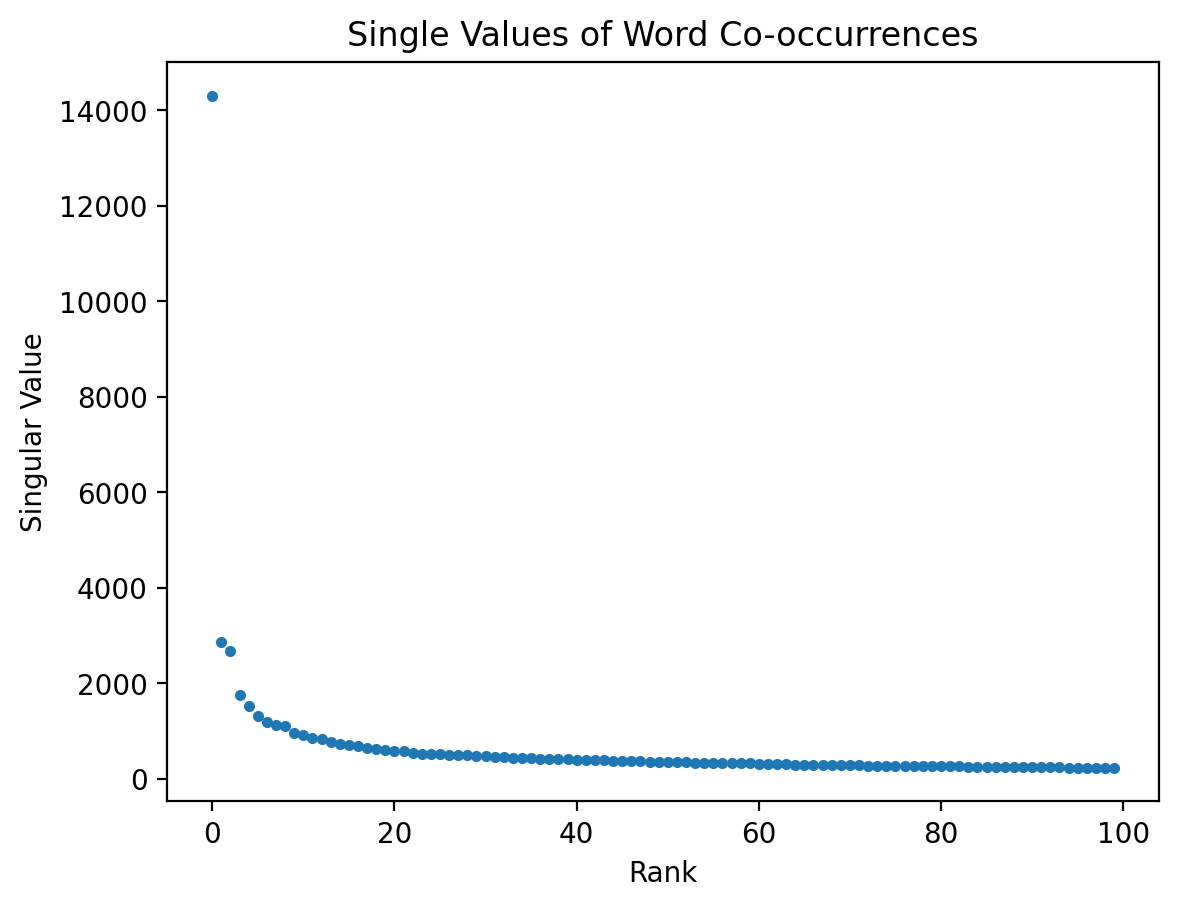

In [44]:
def plot_singular_values(svd_result):
    fig, ax = plt.subplots()
    ax.set_xlabel("Rank")
    ax.set_ylabel("Singular Value")
    ax.set_title("Single Values of Word Co-occurrences")
    ax.plot(svd_result.S, ".")

plot_singular_values(CO_OCCURRENCES_SVD)

$\tilde{M}$ does appear to be close to a low-rank matrix, as there is a quick exponential drop in the singular values after the first few largest ones.